In [26]:
class BuyAndHold_More_Fund(bt.Strategy):
    params = dict(
        monthly_cash=1000,
        initial_cash = 1000
    )

    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        self.broker.set_fundmode(fundmode=True, fundstartval=self.params.initial_cash)
        self.cash_start = self.broker.get_cash()

        # ADD A TIMER
        self.add_timer(
            when=bt.timer.SESSION_START,
            monthdays=[1],
            monthcarry=True
            # timername='buytimer',
        )

    def notify_timer(self, timer, when, *args):
#         print(self.__dict__)
        self.broker.add_cash(self.p.monthly_cash)

        target_value = self.broker.get_value() + self.p.monthly_cash
        self.order_target_value(target=target_value)
        size = math.floor( (self.broker.get_cash()) / self.data[0] )
        print(size)
        self.buy(size=size)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price %.2f, Cost %.2f, Comm %.2f, Size %.0f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm,
                    order.executed.size)
                )

                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            print(order.status, [order.Canceled, order.Margin, order.Rejected])

        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.cash_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('BUY & BUY MORE')
#         print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
        print('#Times:         {:.0f}'.format(self.times))
        print('Value:         ${:,.2f}'.format(value))
        print('Cost:          ${:,.2f}'.format(self.totalcost))
        print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
        print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI:            {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value:     {:.2f}%'.format(self.froi))
#         print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
        print('-'*50)

In [27]:
import math
import backtrader as bt
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

In [28]:
def get_yf_data(ticker="BTC-USD", interval="1d", period="max"): 
    ticker_yf = yf.Ticker(ticker)
    hist = ticker_yf.history(period=period, interval=interval)
    return bt.feeds.PandasData(dataname = hist)

4
2014-09-18, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2014-09-18, BUY EXECUTED, Price 456.86, Cost 1997.93, Comm 0.00, Size 4
2
2014-10-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2014-10-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
6
2014-11-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2014-11-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
7
2014-12-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2014-12-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
12
2015-01-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2015-01-02, BUY EXECUTED, Price 314.08, Cost 3999.91, Comm 0.00, Size 13
4
2015-02-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2015-02-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
7
2015-03-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2015-03-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
12
2015-04-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
2015-04-02, BUY EXECUTED, Price 247.09, Cost 2999.94, Comm 0.00, Size 12
4
2015-05-02, Order Canceled/Margin/Rejected
7 [5

0
2021-11-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
0
2021-12-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
0
2022-01-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
0
2022-02-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
0
2022-03-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
0
2022-04-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
0
2022-05-02, Order Canceled/Margin/Rejected
7 [5, 7, 8]
--------------------------------------------------
BUY & BUY MORE
#Times:         17
Value:         $2,921,265.51
Cost:          $85,999.20
Gross Return:  $2,835,266.32
Gross %:        3296.85%
ROI:            292026.55%
Fund Value:     6217.37%
--------------------------------------------------


<IPython.core.display.Javascript object>


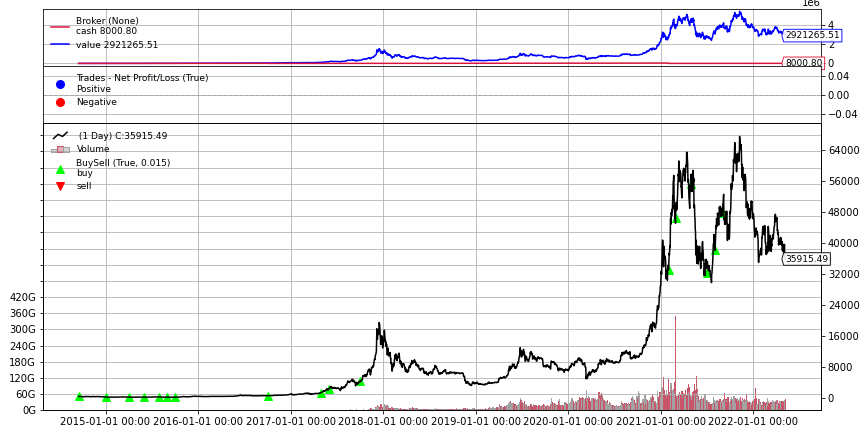

In [29]:
def run(args=None):
    cerebro = bt.Cerebro()
    data = get_yf_data()
    cerebro.adddata(data)  # create and add data feed
    cerebro.addstrategy(BuyAndHold_More_Fund)  # add the strategy
    cerebro.broker.set_cash(1000)  # set broker cash
    cerebro.broker.addcommissioninfo(CommInfoFractional())
    cerebro.run()  # execute
    cerebro.plot()
run()